# RAGを用いた文章検索

このハンズオンでは、GoogleのGemini Proを用いた会話応答文の生成方法と、  
RAGを用いて特定の文章を参照して応答するようにする方法を学んでいきます。

まず必要なライブラリをインストールします。

In [ ]:
!pip install langchain==0.1.13 langchain-google-vertexai==0.1.2 chromadb sentence-transformers lark

notebook全体で使うライブラリを読み込んでおきます。

In [1]:
from IPython.display import Markdown, display
from gcs_utils import GcsUtils
import pandas as pd
import os

データセットが一部GCSにあるので、GCSを読み込む部分も予め定義しておきます。  
gcsがない環境の場合、以下のセルは実行しなくて良いです。

In [2]:
# 研修用gcs環境が使える場合のみTrueにしてください
# use_image = False
use_image = True

In [3]:
PROJECT_ID = "hr-mixi"
BUCKET_NAME = "mixi-ml-handson-2024"
bucket = GcsUtils(
    project_id=PROJECT_ID,
    bucket_name=BUCKET_NAME
)

# Google Gemini Pro 1.5を用いた文章生成
では、試しにGemini Proを用いて文章生成を行ってみましょう。  
なお、今回はLLMsを用いた開発でよく使われるLangChainを使ってGeminiを呼び出しています。

In [4]:
from langchain_google_vertexai import ChatVertexAI
from langchain.schema.messages import HumanMessage

model_name = "gemini-1.5-pro-preview-0409"
gemini_model = ChatVertexAI(model_name=model_name, location='asia-northeast1')

In [5]:
def get_message(text, model=gemini_model):
    return model([HumanMessage(content=[text])])

In [6]:
# questionを任意で変更して、モンストのキャラクターについての質問をしてみてください。また、参考文献を明示するような指示も入れてください。
question = 'モンストのパンドラについて教えてください。 また、参考にした情報を明示してください。'

response = get_message(question)
Markdown(response.content)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


## モンストのパンドラについて

パンドラは、モバイルゲーム「モンスターストライク」に登場するキャラクターです。多くの進化形態を持つのが特徴です。

ここでは、2023年11月までに実装された主なパンドラについて、情報をまとめます。

**参考情報:**

*  モンスト公式サイト
*  ゲームエイト モンスト攻略 Wiki
*  YouTubeなどのモンスト攻略動画

**免責事項:** 私は大規模言語モデルであり、最新の情報やゲームデータの変更をリアルタイムで反映することはできません。

### パンドラの進化形態と特徴

| 名前 | 属性 | タイプ |  特徴 |  
|---|---|---|---|
| 禁忌の獄門番 パンドラ | 光 | バランス |  進化合成で入手可能な初期形態。 |
|  堕冥の万鈞 パンドラ  | 闇 | パワー | 神化合体で入手可能な形態。 | 
|  反逆の堕天使 パンドラ | 闇 | スピード |  獣神化可能な形態。 |
| 禁忌を打破せし者 パンドラ | 光 | バランス |  「禁忌の獄門番 パンドラ」から進化可能な形態。 |
|  廻る悪意の断罪者 パンドラ | 闇 | パワー | 「堕冥の万鈞 パンドラ」から進化可能な形態。 | 
|  螺旋の易簀の悪魔 パンドラ | 闇 | スピード | 「反逆の堕天使 パンドラ」から進化可能な形態。 | 

**各形態の詳細な性能や評価、適正クエストなどは、上記の参考情報などを参照してください。**

### その他

* パンドラは、モンストの中でも人気が高く、様々な進化形態が登場しています。
* コラボイベントなどで、期間限定のパンドラが登場することもあります。

### 注意点

* 上記の情報は、2023年11月時点のものであり、最新の情報とは異なる場合があります。
* 詳細なステータスや評価は、ゲーム内や攻略サイトで確認してください。

何か他に知りたいことがあれば教えてください。

文章の生成はできましたでしょうか？ 生成できた場合、内容は正しそうですか？

# 文章生成の問題点

文章生成の結果は、一見正しそうな結果が返ってきてそうに見えるかと思います。  
しかし、この生成された文章には以下の問題点があります。  

1. **検索結果に精度が左右される**  
デフォルトのquestionで生成した結果には、`参考情報`として、モンスト公式サイトやAppMedia、GameWithなどが  
挙げられていました。この結果から、Gemini Proは、モンストの情報を学習していたのではなく、  
質問を応答する前に検索を行い、その結果の情報を渡しているため、返答ができていると考えられます。  
これらの検索はこちらが指定したものではく、間違っていたり、古いものを参照してしまう可能性があり、  
正確な情報を求められる検索では適切ではなくなってしまいます。


2. **ハルシネーションが起こる**  
デフォルトのquestionで生成した結果を正確に見てみると、一部間違っている情報があることがよくあります。  
一例を挙げると、例えば`パンドラ`が、闇属性なのに`火属性のガチャ限定キャラクター`となっていたり、  
`進化`に実際は所持していないギミックである`アンチダメージウォール`が入ってしまっていることなどがあります。  
このように、文章生成で返答する文は、一見違和感のない文章で、間違っている内容を出力してしまうので注意が必要です。  
またこのような現象のことを、ハルシネーションといいます。  

このような問題に対するアプローチとして、前のセクションで取り組んだTransfer Learningや  
Fine-Tuningといった手法もありますが、LLMはモデルのパラメータが膨大なため、一部の層を  
再学習させるだけでも、相当なコストがかかります。  

そのため、このパートでは、LLMで特定文章を参照してもらいたい時によく使われる  
`RAG(Retrieval-Augmented Generation)`という手法を用いていきます。  
RAGは関連するドメインの文章を予めベクトル化し、質問文のベクトルと照らし合わせて類似度検索を行い、  
関連するドメインの文章を質問文と一緒にLLMの入力に与えることで、その情報を考慮した回答を生成します。  

では、その仕組みをみていきましょう。  

# データセットの確認
まず、今回RAGを使って覚えさせる情報が入っているcsvを読み込みます。

In [7]:
# 今回使うデータセットの読み込み
df = pd.read_csv('monst_char_dict.csv')

In [8]:
# 中身の確認
df.head()

,name,voice,description,personality,birthday,favorite,weak_point,sex,image_summaries
0,クラフト,わぁ、キミもなんだ♡\r\nじゃぁさ、ボクの作った街、\r\n見せちゃうからおいでよ♪,マスターディスクを所持する運命に選ばれた高校生。自分のことを「ボク」と呼ぶが性別は不詳。幼い...,明るく前向きでマイペースだが、ひとつのことに熱中すると周りが見えなくなる,11/18,コツコツ細かい作業を続けること、工事現場めぐり,自分が作ったものを壊す者、自分の作業を邪魔する存在,NaN,クラフトは、緑色の髪と紫色の目で、背が低い少女です。彼女は、紺色と白色のセーラー服を着てお...
1,エリック金光,く、クロスドライブぅ～オン！\r\nもう、ちょっと待ってって\r\n言ったのにぃ～！,金光ミミの子孫にあたる少年。代々続く金光重工の御曹司で、幼い頃から英才教育を受けてきた秀才だ...,気が弱く臆病だが正義感がある,12/10,ひばなさん、メカの設計,喧嘩、気の強い人,男,エリック金光は、モンスターストライクというゲームのキャラクターです。彼は黄色いジャケットを...
2,ゲキリン,心配しなくても大丈夫だって！\r\nこれくらい余裕…って、わぁ！,遠い昔にその世界を創世したといわれる伝説の双龍の娘、ゲキリン。双龍より世界の管理を任されてお...,好奇心旺盛で気になることにはなんでも首を突っ込むタイプ、愛嬌があり人懐こく他人との距離感が近...,8/1,困っている人のお手伝いをすること、人々の穏やかな笑顔、旅先でのおいしいものめぐり,困っている人を放っておくこと、人々に怒りや悲しみを与えるもの、「ゲキリン」という自分の名前の...,女,ゲキリンは、ピンクの髪と黄色の目をした少女です。\n彼女は、紫色の着物と黄色の帯を身に着け...
3,アジテーター,何というツマラナイ世界！\r\nこれを悪夢と言わずして\r\nなんと言おうか♪,元は思慮深く礼儀正しい貴族の紳士だったが、絶望によって狂気の姿へと成り果てた存在。紳士は、貴...,自己中心的で自由奔放な気分屋,NaN,世界をめちゃくちゃにすること,裏切られること,NaN,アジテーターは、頭部が花、胴体がスーツ姿の男性、左腕が包帯でぐるぐる巻きにされたキャラクタ...
4,ユビレギリ,秩序は絶対…守らぬ者は刑に処す…,ただ秩序を守ることだけを目的として生きる、秩序欲求の化身たる存在。どんな小さな約束事も、些細...,イエスかノーしかない極端な性格,NaN,秩序、ルール,秩序の乱れ、ルール違反,NaN,ユビレギリは、片目に眼帯を付け、ボロボロのローブを纏った老婆のような姿をしています。\n背...


中身を見てみると、モンストのキャラクター情報や、一言メッセージ、
キャラの説明、性格や誕生日等の情報があります。  
また、image_summariesには、キャラクターの画像を説明しているテキストがあります。  
これらのデータセットは、[モンストディクショナリー](https://dic.xflag.com/monsterstrike/)を参考に作られているので、確認してみてください。

# 各要素におけるdictの作成

次に、RAGに合わせて、データの分割をおこなっていきます。  
ここでは、構成する要素に合わせてcsv(df)データから、  
text_dict、image_dict、metadata_dictの3つを作っていきます。  
それぞれの役割は以下の通りです。  

- **text_dict**  
キャラクター毎のテキスト情報がまとめられており、主にこれをベクトル化していくことで検索を行う。
- **image_dict**  
キャラクター毎の画像の名前と説明が入っており、関連画像を参考情報としてgemini proに入力することで検索を補助する。
- **metadata_dict**  
metadataとして使われるものがまとめられており、主に検索時に、metadataを使うことでフィルタリングを行う。

では、実行していきましょう。

In [9]:
def create_dicts_from_csv(df):
    image_name_list = []
    desc_list = []
    text_list = []
    metadata_name_list = []
    metadata_birthday_list = []
    metadata_sex_list = [] 

    for index, row in df.iterrows():         
        # image_dict の作成 (既にあるsummariesとnameだけなので、名前だけ作成)
        image_name_list.append(f"{row['name']}" if pd.notnull(row['name']) else "")

        # text_dict
        text_elements = [
            f"名前: {row['name']}" if pd.notnull(row['name']) else "",
            f"一言: {row['voice']}" if pd.notnull(row['voice']) else "",
            f"性格: {row['personality']}" if pd.notnull(row['personality']) else "",
            f"誕生日: {row['birthday']}" if pd.notnull(row['birthday']) else "",
            f"好きなもの: {row['favorite']}" if pd.notnull(row['favorite']) else "",
            f"苦手なもの: {row['weak_point']}" if pd.notnull(row['weak_point']) else "",
            f"性別: {row['sex']}" if pd.notnull(row['sex']) else "",
            f"プロフィール: {row['description']}" if pd.notnull(row['description']) else "",
            f"容姿: {row['image_summaries']}" if pd.notnull(row['image_summaries']) else ""                
        ]
        text = ', \n '.join(filter(None, text_elements))
        text_list.append(text)
        
        # metadata_dict
        metadata = {}
        metadata_name_list.append(f"{row['name']}" if pd.notnull(row['name']) else "")
        metadata_birthday_list.append(f"{row['birthday']}" if pd.notnull(row['birthday']) else "")
        metadata_sex_list.append(f"{row['sex']}" if pd.notnull(row['sex']) else "")
    
    image_dict = {'name': image_name_list, 'summaries': df['image_summaries'].values.tolist()}
    text_dict = {'texts': text_list}
    metadata_dict = {'name': metadata_name_list, 'birthday': metadata_birthday_list, 'sex': metadata_sex_list}
    
    return image_dict, text_dict, metadata_dict

In [10]:
image_dict, text_dict, metadata_dict = create_dicts_from_csv(df)

これで、各構成要素に合わせたdictが用意できました。

# Retrieverの作成

データが用意できたので、RAGを定義していきます。  
RAGでは、Retrieverというものを使って、ドメインに関連情報する情報を検索します。　　

今回は`ParentDocumentRetriever`と`SelfQueryRetriever`の2つを使って、関連情報の検索を行います。  
ではそれぞれ、実装をみていきましょう。

## ParentDocumentRetriever
ParentDocumentRetrieverは、検索する際にドキュメントの文章から検索するのではなく、  
検索用の文章を使って検索し、その検索用の文章に紐づいたドキュメントをLLMに渡すという  
仕組みを実現するために定義されたRetrieverです。

なぜこのような仕組みが用意されているかというと、一般的に、LLMに文章を渡す際は  
詳細な情報も含めた文章を渡した方が精度が上がりやすいのですが、逆に検索用の文章は長すぎると、  
特徴が平均化されてしまうため検索精度が下がってしまうという問題があります。  
こういった問題に対処するために用意されているRetrieverとなります。

今回はtext_dictのtextsに対して改行毎に区切って、それを検索用の文章としたいので、  
textsを要素毎に改行で区切るように、修正していきましょう。

In [11]:
# 改行で区切る
# テキストデータを要素ごとに改行で区切る
def reformat_text(text_list):
    formatted_texts = []
    for text in text_list:
        formatted_text = ""
        attributes = text.split(', \n')
        for attribute in attributes:
            key, value = attribute.split(': ', 1)
            # 余計な改行をスペースに置き換え
            value = value.replace('\r\n', ' ').replace('\n', '')
            # カンマで区切られた値を結合
            value = value.replace('、', '、 ')
            key = key.replace(' ', '')
            # 。で終わっている場合は改行
            value = value.replace('。', '。\n')
            formatted_text += f"{key}: {value}\n"
        formatted_texts.append(formatted_text.strip())  # 末尾の不要な改行を削除
    return formatted_texts

# 整理されたテキストデータを取得
formatted_texts = reformat_text(text_dict['texts'])
text_dict['texts'] = formatted_texts

うまく要素毎に改行で分割できているか確認してみましょう

In [12]:
print(str(text_dict['texts'][0]))

名前: クラフト
一言: わぁ、 キミもなんだ♡ じゃぁさ、 ボクの作った街、  見せちゃうからおいでよ♪
性格: 明るく前向きでマイペースだが、 ひとつのことに熱中すると周りが見えなくなる
誕生日: 11/18
好きなもの: コツコツ細かい作業を続けること、 工事現場めぐり
苦手なもの: 自分が作ったものを壊す者、 自分の作業を邪魔する存在
プロフィール: マスターディスクを所持する運命に選ばれた高校生。
自分のことを「ボク」と呼ぶが性別は不詳。
幼い頃から手先が器用で手芸や工芸などのモノづくりが得意だったこともあり、 周囲の人々から何かと頼りにされることが多く、 自身もそれに喜びを覚えるようになった。
そんな趣味が高じて、 クラフト系のシミュレーションゲーム『ギャラクシーシティ・クラフト』にハマったが、 マスターディスクの能力に目覚めたことで誰よりも精巧で完璧なモノづくりを求め続けるようになり、 その邪魔をする存在を排除するようになってしまった。

容姿:  クラフトは、 緑色の髪と紫色の目で、 背が低い少女です。
彼女は、 紺色と白色のセーラー服を着ており、 スカートにはチェック柄が入っています。
また、 彼女は、 紫色のネクタイを締めており、 紺色のニーソックスを履いています。
彼女は、 左手に紫色のつるはしを持っており、 右手でそれを振りかざしています。
彼女の周りには、 紫色の結晶が浮遊しています。


これで、データの準備は完了しました。

次に、ドキュメントをベクトル化(embedding)するためのモデルを用意します。  
今回は、多言語対応モデルで日本語に対しての精度が高いと言われている[multilingual-e5-large](https://huggingface.co/intfloat/multilingual-e5-large)を使用します。

In [13]:
from huggingface_hub import snapshot_download

model_name = "intfloat/multilingual-e5-large"
download_path = snapshot_download(
    repo_id=model_name,
    local_dir = f"model/{model_name.split('/')[-1]}",
    local_dir_use_symlinks=False 
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1212: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

In [14]:
from langchain.embeddings import HuggingFaceEmbeddings

model_path = 'model/multilingual-e5-large'
embeddings = HuggingFaceEmbeddings(model_name=model_path)

これでデータとベクトル化用のモデルの用意が終わったので、`ParentDocumentRetriever`を定義していきます。  
まず、必要なmoduleをimportします。

In [15]:
import uuid

from langchain.embeddings import VertexAIEmbeddings
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma
from langchain_core.documents import Document
from langchain.retrievers import ParentDocumentRetriever
from langchain.text_splitter import CharacterTextSplitter

次に、ParentDocumentRetrieverを取得するためのメソッドを定義します。  
ここでは、主に3つの変数を定義し、ParentDocumentRetrieverに渡しています。
- **vectorstore**  
ベクトルで検索する時に使用される文章を`ChromaDB`を用いて格納する
- **docstore**  
ドキュメント単位での文章を`InMemoryStore`を用いて格納する
- **splitter**  
ドキュメントを改行で分割するために、`CharacterTextSplitter`を用いて定義する

これら3つの変数をParentDocumentRetrieverに渡すことで、  
Retriever内でドキュメントの改行毎にsubdocを作成し、vectorestoreに格納してくれるようになります。  

最後にドキュメントをRetrieverに追加して、retrieverを返すまでがこのメソッドの全貌となります。  
では、実際にメソッドを実行してみてみましょう。

## TODO
ParentDocumentRetrieverに適切なクラスインスタンスを指定してください。

In [16]:
def get_parent_retriever(text_dict, embeddings=embeddings):
    vectorstore = Chroma(
        collection_name="gemini-pro-text-rag",
        embedding_function=embeddings
    )

    # 元の文章を保存するためのストレージ
    store = InMemoryStore()
    id_key = "doc_id"
    
    # inputを改行で区切ってsubdocを作成するためのsplitterを定義する
    child_splitter = CharacterTextSplitter(separator="\n", chunk_size=1, chunk_overlap=0)
    
    retriever = ParentDocumentRetriever(
        vectorstore=vectorstore, 
        docstore=store,
        child_splitter=child_splitter,
        id_key=id_key,
        search_kwargs={"k": 10},
    )
    
    # テキストデータをembedding、vectorstoreに格納する
    doc_ids = [str(uuid.uuid4()) for _ in text_dict["texts"]]
    # チャンクを保存する
    for i, s in enumerate(text_dict["texts"]):
        if s != "":
            retriever.add_documents(
                [Document(page_content=s, metadata={id_key: doc_ids[i]})]
            )

    return retriever

In [17]:
# 下記コードはsplit毎にlogが流れるので、実行後に最小化しても問題ないです。
parent_retriever = get_parent_retriever(text_dict)

Created a chunk of size 8, which is longer than the specified 1
Created a chunk of size 44, which is longer than the specified 1
Created a chunk of size 41, which is longer than the specified 1
Created a chunk of size 10, which is longer than the specified 1
Created a chunk of size 31, which is longer than the specified 1
Created a chunk of size 33, which is longer than the specified 1
Created a chunk of size 32, which is longer than the specified 1
Created a chunk of size 20, which is longer than the specified 1
Created a chunk of size 79, which is longer than the specified 1
Created a chunk of size 124, which is longer than the specified 1
Created a chunk of size 33, which is longer than the specified 1
Created a chunk of size 42, which is longer than the specified 1
Created a chunk of size 41, which is longer than the specified 1
Created a chunk of size 39, which is longer than the specified 1
huggingface/tokenizers: The current process just got forked, after parallelism has already

実行が完了したら、試しに投げてみましょう  
textsの一番目のキャラクターのプロフィールを参考に、正しい検索ができているかクエリを投げてみます。

In [18]:
print(text_dict['texts'][0])

名前: クラフト
一言: わぁ、 キミもなんだ♡ じゃぁさ、 ボクの作った街、  見せちゃうからおいでよ♪
性格: 明るく前向きでマイペースだが、 ひとつのことに熱中すると周りが見えなくなる
誕生日: 11/18
好きなもの: コツコツ細かい作業を続けること、 工事現場めぐり
苦手なもの: 自分が作ったものを壊す者、 自分の作業を邪魔する存在
プロフィール: マスターディスクを所持する運命に選ばれた高校生。
自分のことを「ボク」と呼ぶが性別は不詳。
幼い頃から手先が器用で手芸や工芸などのモノづくりが得意だったこともあり、 周囲の人々から何かと頼りにされることが多く、 自身もそれに喜びを覚えるようになった。
そんな趣味が高じて、 クラフト系のシミュレーションゲーム『ギャラクシーシティ・クラフト』にハマったが、 マスターディスクの能力に目覚めたことで誰よりも精巧で完璧なモノづくりを求め続けるようになり、 その邪魔をする存在を排除するようになってしまった。

容姿:  クラフトは、 緑色の髪と紫色の目で、 背が低い少女です。
彼女は、 紺色と白色のセーラー服を着ており、 スカートにはチェック柄が入っています。
また、 彼女は、 紫色のネクタイを締めており、 紺色のニーソックスを履いています。
彼女は、 左手に紫色のつるはしを持っており、 右手でそれを振りかざしています。
彼女の周りには、 紫色の結晶が浮遊しています。


In [19]:
parent_retriever.get_relevant_documents("工場現場巡りが好きなキャラクターを教えてください")

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


[Document(page_content='名前: クラフト\n一言: わぁ、 キミもなんだ♡ じゃぁさ、 ボクの作った街、  見せちゃうからおいでよ♪\n性格: 明るく前向きでマイペースだが、 ひとつのことに熱中すると周りが見えなくなる\n誕生日: 11/18\n好きなもの: コツコツ細かい作業を続けること、 工事現場めぐり\n苦手なもの: 自分が作ったものを壊す者、 自分の作業を邪魔する存在\nプロフィール: マスターディスクを所持する運命に選ばれた高校生。\n自分のことを「ボク」と呼ぶが性別は不詳。\n幼い頃から手先が器用で手芸や工芸などのモノづくりが得意だったこともあり、 周囲の人々から何かと頼りにされることが多く、 自身もそれに喜びを覚えるようになった。\nそんな趣味が高じて、 クラフト系のシミュレーションゲーム『ギャラクシーシティ・クラフト』にハマったが、 マスターディスクの能力に目覚めたことで誰よりも精巧で完璧なモノづくりを求め続けるようになり、 その邪魔をする存在を排除するようになってしまった。\n\n容姿:  クラフトは、 緑色の髪と紫色の目で、 背が低い少女です。\n彼女は、 紺色と白色のセーラー服を着ており、 スカートにはチェック柄が入っています。\nまた、 彼女は、 紫色のネクタイを締めており、 紺色のニーソックスを履いています。\n彼女は、 左手に紫色のつるはしを持っており、 右手でそれを振りかざしています。\n彼女の周りには、 紫色の結晶が浮遊しています。', metadata={'doc_id': '77dacce6-6a33-40ca-ba8f-41a929b012e1'}),
 Document(page_content='名前: 機光院チヨ\n一言: えへへ～、 私の最高傑作だよ♪ストライクショット！\n性格: 引っ込み思案で大人しいが、 メカのことに関しては頑固で理屈っぽくなる一面も\n誕生日: 2/11\n好きなもの: 科学、 メカいじり、 ジェラルド（自信をくれるから）\n苦手なもの: 人と喋ること、 誰かが傷つくこと、 イヴ（いつも怒っているから）\n性別: 女\nプロフィール: 特殊防衛部隊MDTの技術開発部門に所属する日本出身の新人兵士。\n人と話すことが苦手で、 機械に対してのみ普通に喋ることができる引っ込み思案

一番類似度が高いものとtextsに入っているもの(クラフト)が一致しているでしょうか？

## SelfQueryRetriever
SelfQueryRetrieverは主にMetadataフィルタイングをしたい時に使用されるRetrieverとなります。  
このRetrieverを使うと、metadataを含む質問がされた場合に、中のLLMがその質問を解析し、  
metadataに応じたフィルタを作ってくれるようになります。  
LLMでの検索は、一致検索の精度に難があるので、このようにフィルタリングを行うことで、  
`誕生日`や`性別`といったものの一致検索に対しても高い精度を保てるようになります。  

では、実装を見ていきます。

In [20]:
from datetime import datetime

from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

検索の精度の関係上、日付に当たるbirthdayを、`mm-dd`方式にし、また、月や日にち単体でも  
検索できるようにそれぞれを別のものとして再定義します。

In [21]:
def format_date(date_str):
    # 日付を mm-dd, month, dayを出力する
    try:
        date = datetime.strptime(date_str, '%m/%d')
        return date.strftime('%m-%d'), str(int(date.strftime('%m'))), str(int(date.strftime('%d')))
    except ValueError:
        # 日付の形式が正しくない場合はNoneを返す
        return "", "", ""

では、SelfQueryRetrieverを取得するためのメソッドを定義します。  
今回はドキュメントを格納するvectoresotreのみ定義し、その中にドキュメントを追加していくのですが、  
そこでmetadataを定義するようにします。　　

metadataは以下の5つを定義しています。
- **name** 名前
- **birthday** 誕生日
- **birthday_month** 誕生月
- **birthday_day** 誕生日の日にち
- **sex** 性別

また、同時に画像の検索を行っているので、画像の要約もvectorestoreに追加しており、  
その際metadataに`容姿`という情報を追加しています。  
後の処理で、LLMでの検索時に`容姿`を含むmetadataの情報が関連する資料として取得できた場合、  
そのキャラクターの画像を出力するという構成をとっているため、このようなmetadataを追加しています。

これら3つの変数をParentDocumentRetrieverに渡すことで、  
Retriever内でドキュメントの改行毎にsubdocを作成し、vectorestoreに格納してくれるようになります。  

また、metadataとして登録したものはAttributeInfoを使って属性の定義をする必要があるので、  
メソッド内でその定義を行い、metadataのフィルタ生成をするためのLLMとして`gemini pro`を指定します。  
最後に定義したものをRetrieverに渡し、そのRetrieverを返すまでがこのメソッドの処理になります。  

では、このメソッドも実行していきましょう。

## TODO
SelfQueryRetrieverに適切なクラスインスタンスを指定してください。

In [22]:
def get_self_query_retriever(text_dict, image_dict, metadata_dict, examples, model_name=""):
    vectorstore = Chroma(
        collection_name="gemini-pro-multi-rag",
        embedding_function=embeddings,
    )

    # 元の文章を保存するためのストレージ
    store = InMemoryStore()
    id_key = "doc_id"
    
    # テキストデータをembedding、vectorstoreに格納する
    doc_ids = [str(uuid.uuid4()) for _ in text_dict["texts"]]
    
    # チャンクを保存する
    # この時、metadataとして定義したものをtextと一緒にdocumentに追加しておく
    for i, s in enumerate(text_dict["texts"]):
        if s != "":
            birthday, birthmonth, birthday_day = format_date(metadata_dict['birthday'][i])
            vectorstore.add_documents(
                [Document(page_content=s, metadata={
                    id_key: doc_ids[i],
                    "name": metadata_dict['name'][i],
                    "birthday": birthday,
                    "birthday_month": birthmonth,
                    "birthday_day": birthday_day,                    
                    "sex": metadata_dict['sex'][i]                   
                })]
            )
            
    print("Text Data Stored!!")

    # 画像の要約をembedding、vectorstoreに格納する
    img_sum_ids = [str(uuid.uuid4()) for _ in image_dict["summaries"]]
    
    # チャンクを保存する
    # この時、metadataとして名前と'容姿'という情報を追加しておく
    for i, summary in enumerate(image_dict["summaries"]):
        if s != "":
            vectorstore.add_documents(
                [Document(page_content=summary, metadata={
                    id_key: img_sum_ids[i],
                    "name": image_dict['name'][i],
                    "appearance": '容姿'
                })]
            )
    print("Image Summaries Data Stored!!")    
    
    # metadataとして登録したもののattributeを定義
    metadata_field_info = [
        AttributeInfo(
            name="name",
            description="Character Name",
            type="string",
        ),
        AttributeInfo(
            name="birthday",
            description="Character Birthday",
            type="string",
        ),
        AttributeInfo(
            name="birthday_month",
            description="Character Birthday Month",
            type="string",
        ),
        AttributeInfo(
            name="birthday_day",
            description="Character Birthday Day",
            type="string",
        ),         
        AttributeInfo(
            name="sex",
            description="Character Sex",
            type="string",
        ),
        AttributeInfo(
            name="appearance",
            description="Character Image Description",
            type="string",
        ),          
    ]
    
    # フィルタ作成に使用するLLMの定義
    document_content_description = "モンスターストライク(モンスト)におけるキャラクターの情報と容姿についての説明"
    if model_name == "":
        model_name = "gemini-1.5-pro-preview-0409"
        llm = ChatVertexAI(model_name=model_name)
    
    return SelfQueryRetriever.from_llm(
        llm, vectorstore, document_content_description, metadata_field_info, verbose=True,
        chain_kwargs={
            "examples": examples
        },
        search_kwargs={
            "k": 4
        }
    )

また、変数としてメソッド内で定義されていないexamplesを引数として受け取り、  
Retrieverに渡していますが、これは、filter作成の精度向上のため、  
いくつかの事例を用意して渡すための変数となります。  
下記の形で、いくつか定義しておきます。  

In [23]:
examples = [
    (
        "誕生日が03月01日のキャラクターはなんですか？",
        {
            "query": "誕生日が3月1日のキャラクター",
            "filter": 'and(eq("birthday_month", "3"), eq("birthday_day", "1"))',
        },
    ),
    (
        "ルシファーについて教えてください",
        {
            "query": "ルシファーについて教えてください",
            "filter": 'eq("name", "ルシファー")',
        },
    ),    
    (
        "ルシファーの画像をください",
        {
            "query": "ルシファーの画像",
            "filter": 'and(eq("name", "ルシファー"), eq("appearance", "容姿"))',
        },
    ),
    (
        "ルシファーの容姿を教えてください",
        {
            "query": "ルシファーの容姿",
            "filter": 'and(eq("name", "ルシファー"), eq("appearance", "容姿"))',
        },
    )    
]

それでは、self_query_retrieverを作っていきましょう

In [24]:
self_query_retriever = get_self_query_retriever(
    text_dict, image_dict, metadata_dict, examples
)

Text Data Stored!!
Image Summaries Data Stored!!


完成したら、関連するドキュメントをとって精度を確認してみましょう

In [25]:
self_query_retriever.invoke("誕生日が7月7日のキャラクターを教えてください")

[Document(page_content='名前: ザグマス\n一言: テメェら勇者の一味だな？悪いがここを通すわけにはいかねぇ…！\n性格: 豪快で大雑把だが仲間想いで情に厚い\n誕生日: 7/7\n好きなもの: 航海、 肉、 友情\n苦手なもの: 細かいことを考えること\n性別: 男\nプロフィール: 海賊団を率いるカニの戦士。\nかつてロイゼと共に世界を救ったレオニダルスと同じ魚人族であり、 ロイゼの仲間として彼を護り抜いたレオニダルスのことを魚人族の英雄であり、 誇りに思っている。\nロイゼが魔王を討伐し王国を作った際、 魚人族である自分が王国にいると人間たちを脅かしてしまうという考えから、 ロイゼとの友情を重んじる意味でレオニダルスは王国を去ったのだが、 ザグマスはその事実を「魚人族が人間に迫害を受けた」と誤解しており、 それ故にロイゼの一族に対して強い憎しみを抱いている。\n\n容姿:  ザグマスは、 片目が眼帯で隠され、 もう片方の目は小さくつり上がっています。\n口は大きく裂けていて、 鋭い牙が覗いています。\n体は筋肉質で、 カニのような甲羅とハサミを持っています。\n頭には赤い三角帽子をかぶり、 腰には2丁のピストルを差しています。\n左腕には木製の樽を、 右手には碇を抱えています。\n彼は海賊船に乗っており、 船には仲間のモンスターである「クラーケン」と「キャプテン・ピッグ」が乗っています。', metadata={'birthday': '07-07', 'birthday_day': '7', 'birthday_month': '7', 'doc_id': 'a46a28b2-3bc7-4a93-bf6e-24d328db96ce', 'name': 'ザグマス', 'sex': '男'}),
 Document(page_content='名前: 数珠丸恒次\n一言: これでまた一つ…もっと…もっと斬らないと…\n性格: 根暗で独創的、 どこか達観している部分がある性格\n誕生日: 7/7\n好きなもの: 母上、 褒められること、 おはぎ\n苦手なもの: 感情を表現すること、 人にあわせること\n性別: 女\nプロフィール: 天下五剣と評される剣客の一人であり、 妖異を封じることを生業としている一族の少女。\n妖力を閉じ込めた数珠を

精度はどうでしょうか  
問題なければ、これでretrieverの定義は完了です。

# Chainの作成  
では、最後に質問からドキュメントの検索を行い、関連情報を含めたプロンプトを作成し  
LLMから回答を受け取るまでのフローを作成していきます。

In [26]:
from langchain_google_vertexai import VertexAI, HarmCategory, HarmBlockThreshold
from vertexai import generative_models

モンストディクショナリーの情報を使った検索にあたり、強めのワードに関する制限をオフにする設定を定義します。  
これは、モンストの世界はあくまでゲームの世界のため、強い表現があり(「下僕」など)、  
それが制限に引っかかる可能性があるためです。  
しかし、実際にサービスに入れるときなどはこれらの設定を適切に設定することを心に留めておいてください。  
また、今回のモデルに置いても **社会良俗に反することは入力しない** ようにしてください。  

In [27]:
safety_settings = {
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
}

Chainを作る際に呼び出すメソッドを定義していきます。  
まず、generate_promptメソッドを用意します。  
このメソッドは、各retrieverから受け取った関連情報を使い最終的なLLMへの入力となるテキストのプロンプトを作成します。  
また、受け取った関連情報に画像の要約の情報が含まれていたら、画像を出力するようにすると同時に、  
LLMの入力に画像を含んだデータを渡すようにします。

In [28]:
from base64 import b64encode

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def plt_image(image_data):
    image = Image.open(image_data)
    # 画像を表示
    plt.imshow(image)
    plt.axis("off")
    plt.show()


def generate_prompt(data):
    prompt_template = f"""
        contextや画像には、モンスターストライク(通称モンスト)のキャラクター情報が与えられます。
        以下の質問に対して、モンストと関連する質問に対しては、contextおよび写真を参考にして質問に答えてください。
        なお、contextには質問と関係ないものが入ることもありますので、その場合は無視をしてください。
        画像に対しても、関係ない場合は無視をしてください。
        モンストと関連する質問に対し、contextや内容を使ってもわからなかった場合は、分かりませんという回答をしてください。
        モンストに関連する質問でないと判断した場合は、contextの情報や画像の情報を使わず、内容に対しての回答をしてください。

        内容:
        {data["question"]}

        context1:
        {data["context1"]}
        
        context2:
        {data["context2"]}    
        """
    text_message = {"type": "text", "text": prompt_template}

    # 画像がRetrivalで取得された場合には画像を追加,エンコードしてmatplotlibで表示する
    # context2の関連性が最も高い要素が'容姿'だった場合モデルに画像を含めて入力する
    if len(data["context2"]) > 0 and use_image:
        doc = data["context2"][0]
        if 'appearance' in doc.metadata:
            name = doc.metadata['name']
            name_path = f"monst_dic/images/{name}.png"
            print(name_path)
            try:
                image_data = bucket.read_file_from_gcs(name_path)
            except:
                print("gcsのbucketが認識できていません。　設定するか、use_imageをfalseにしてください・")
            plt_image(image_data)
            image_b64 = b64encode(image_data.getvalue()).decode("utf-8")
            image_url = f"data:image/jpeg;base64,{image_b64}"
            image_message = {"type": "image_url", "image_url": {"url": image_url}}
            return [HumanMessage(content=[text_message, image_message])]
    return [HumanMessage(content=[text_message])]

次に、get_response_from_modelを定義します。  
これは、generate_promptで生成されたpromptを使ってGemini Proに質問を投げ、  
返ってきた返答を返しているだけのメソッドとなります。

## TODO
事前に定義したVertexAIのgeminiモデルを埋めてください

In [29]:
# モデルにqueryを投げて返答を受け取る
def get_response_from_model(message, model_name = ""):
    if model_name == "":
        model_name = "gemini-1.5-pro-preview-0409"
    model = ChatVertexAI(model_name=model_name, safety_settings=safety_settings)
    response = model(message)
    return response

最後にこれらのメソッドを使ってチェインを定義していきましょう。

## TODO
穴あき箇所に定義した関数を埋めてchainを完成させてください

In [30]:
from langchain.schema.output_parser import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough


# Chainを作成、実行する
def multimodal_rag(parent_retriever, self_query_retriever , question: str) -> str:
    chain = (
        {
            "context1": parent_retriever,
            "context2": self_query_retriever,
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(generate_prompt)
        | RunnableLambda(get_response_from_model)
        | StrOutputParser()
    )
    answer = chain.invoke(question)
    return answer

これで、RAGを用いた文書検索部分の実装は完了です。

# 結果の確認

では、questionに質問を用意し、結果の確認をしてみましょう

In [31]:
question_1 = "誕生日が1/1のキャラクターを教えてください"
answer_1 = multimodal_rag(parent_retriever, self_query_retriever, question_1)
Markdown(answer_1)

ネオ、蓬莱、スノードロップです。 


monst_dic/images/ネオ.png


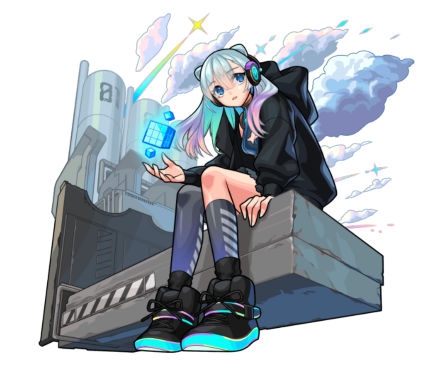

ネオは、モンスターストライクに登場するキャラクターです。彼女は銀髪で、右目にヘッドホンをつけており、黒いパーカーを着ています。パーカーには白い星が描かれており、パーカーの下には白いスカートを身に着けています。また、ニーハイソックスを履き、黒と黄色のスニーカーを履いています。ネオは、機械のようなものに囲まれた場所で、空に浮かぶ立方体を眺めています。彼女の表情は、穏やかで、どこか物憂げな印象を受けます。

In [32]:
question_2 = "モンストのネオについて、画像も含めて詳細に教えてください。"
answer_2 = multimodal_rag(parent_retriever, self_query_retriever, question_2)
Markdown(answer_2)

モンストディクショナリーを参考に、正しい情報を出力することができたでしょうか？

好きな質問を入れて、どんな出力を得られるか試してみましょう！

In [33]:
# todo 好きな検索を入れてみよう
question = "モンストにおいて、容姿が金髪である女性キャラクターを詳細に教えてください。"
answer = multimodal_rag(parent_retriever, self_query_retriever, question)
Markdown(answer)

アップルは、金髪で、赤いフード付きジャケットを着ています。